In [1]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.2' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from temgym_core.ray import Ray
from temgym_core.source import ParallelBeam
from temgym_core.components import Detector, Lens, Deflector, Plane
from temgym_core.gaussian import GaussianRay, evaluate_gaussian_input_image, make_gaussian_image
from temgym_core.utils import fibonacci_spiral, FresnelPropagator
import numpy as np

from __future__ import annotations
import numpy as np
from skimage.restoration import unwrap_phase

from temgym_core.run import run_to_end, run_iter
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

## 1. General definition of curvature

For a **plane curve** $y=f(x)$, you can think of the curve as parameterized in Cartesian coordinates:

$$
\vec{r}(x) = \big(x, f(x)\big).
$$

The **tangent vector** is

$$
\vec{t}(x) = \frac{d\vec{r}}{dx} = \big(1, f'(x)\big).
$$

The **unit tangent vector** is

$$
\hat{t}(x) = \frac{\vec{t}(x)}{\|\vec{t}(x)\|} 
= \frac{(1, f'(x))}{\sqrt{1 + (f'(x))^2}}.
$$

Curvature, by definition, is the **rate of change of the tangent direction with respect to arc length $s$**:

$$
\kappa = \left\| \frac{d\hat{t}}{ds} \right\|.
$$

Then the **radius of curvature** is its reciprocal:

$$
R = \frac{1}{\kappa}.
$$

---

## 2. Relation between arc length and x

Arc length is defined as

$$
ds = \sqrt{1 + (f'(x))^2}\,dx.
$$

So the derivative with respect to arc length is

$$
\frac{d}{ds} = \frac{1}{\sqrt{1+(f'(x))^2}} \frac{d}{dx}.
$$

---

## 3. Differentiate the tangent vector

Differentiate the unit tangent vector $\hat{t}(x)$:

$$
\hat{t}(x) = \frac{(1, f'(x))}{\sqrt{1+(f'(x))^2}}.
$$

Its derivative w\.r.t. $x$ is

$$
\frac{d\hat{t}}{dx} = \frac{(0, f''(x))}{\sqrt{1+(f'(x))^2}} \;-\; 
\frac{(1, f'(x)) \cdot f'(x) f''(x)}{(1+(f'(x))^2)^{3/2}}.
$$

That simplifies (with some algebra) to a vector whose magnitude is

$$
\left\| \frac{d\hat{t}}{dx} \right\| 
= \frac{|f''(x)|}{\big(1+(f'(x))^2\big)^{3/2}}.
$$

---

## 4. Convert to derivative w\.r.t. arc length

Now divide by $ds/dx = \sqrt{1+(f'(x))^2}$:

$$
\left\|\frac{d\hat{t}}{ds}\right\| = 
\frac{|f''(x)|}{\big(1+(f'(x))^2\big)^{3/2}}.
$$

That’s the **curvature**:

$$
\kappa(x) = \frac{|f''(x)|}{\big(1+(f'(x))^2\big)^{3/2}}.
$$

---

## 5. Radius of curvature

Finally, radius of curvature is just the reciprocal:

$$
R(x) = \frac{\big(1+(f'(x))^2\big)^{3/2}}{|f''(x)|}.
$$

### 2D surface z = f(x,y)

At a point (x,y), the principal radii of curvature are the reciprocals of the principal curvatures (the eigenvalues of the shape operator):

$$
R_{1,2}(x,y) \;=\; \frac{1}{\kappa_{1,2}(x,y)}.
$$

Define the first and second fundamental form coefficients:

$$
\begin{aligned}
E &= 1 + f_x^2, &\quad F &= f_x f_y, &\quad G &= 1 + f_y^2, \\
L &= \dfrac{f_{xx}}{\sqrt{1+f_x^2+f_y^2}}, &\quad
M &= \dfrac{f_{xy}}{\sqrt{1+f_x^2+f_y^2}}, &\quad
N &= \dfrac{f_{yy}}{\sqrt{1+f_x^2+f_y^2}}.
\end{aligned}
$$

The principal curvatures κ1, κ2 are the eigenvalues of the 2×2 matrix product:

$$
\begin{bmatrix} \kappa_1 & 0 \\[4pt] 0 & \kappa_2 \end{bmatrix}
\quad\text{with}\quad
\begin{bmatrix} \kappa_1 \\[2pt] \kappa_2 \end{bmatrix}
\text{ from eigenvalues of }
\begin{bmatrix} E & F \\[2pt] F & G \end{bmatrix}^{-1}
\begin{bmatrix} L & M \\[2pt] M & N \end{bmatrix}.
$$

In [2]:
import jax
import jax.numpy as jnp

# Example parameters
focal_length = 0.5  # 1 mm

# Define the optical path length (OPL) function
def opl(x, y):
    return (x**2 + y**2) / (2 * focal_length)

# Restrict to 1D slice (y = 0)
def opl_1d(x):
    return opl(x, 0.0)

# First and second derivatives
d_opl = jax.grad(opl_1d)
d2_opl = jax.grad(d_opl)

# Radius of curvature function in 1D
def R_of_x(x):
    slope = d_opl(x)
    curvature = d2_opl(x)
    return (1.0 + slope**2)**1.5 / curvature

# Grid for evaluation
x_line = jnp.linspace(-0.1, 0.1, 101)
parabola_x = x_line
opl_line = jax.vmap(opl_1d)(x_line)
slope_line = jax.vmap(d_opl)(x_line)
R_line = jax.vmap(R_of_x)(x_line)

# --- choose points to plot vectors ---
idx = jnp.array([50, 50])

# slope at sampled points
m_s = slope_line[idx]

# fixed arrow length in x
arrow_len_x = (x_line[-1] - x_line[0]) * 0.05

# normalization factor
norm_t = jnp.sqrt(1 + m_s**2)

# tangent vectors (unit tangent scaled to arrow_len_x in x)
tx = arrow_len_x / norm_t
ty = m_s * arrow_len_x / norm_t

# normal vectors (perpendicular to tangent, same scaling)
nx = -m_s * arrow_len_x / norm_t
ny = arrow_len_x / norm_t

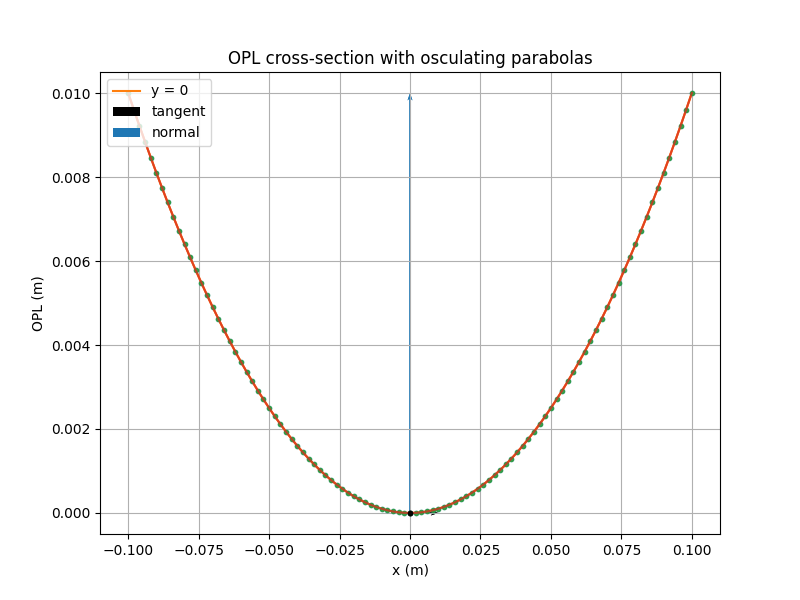

In [3]:
# --- plotting ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_line, opl_line, 'C1-', label='y = 0')

ax.quiver(x_line[idx], opl_line[idx], tx, ty,
          angles='xy', scale_units='xy', scale=1,
          color='k', width=0.002, headwidth=4, headlength=6,
          label='tangent')

ax.quiver(x_line[idx], opl_line[idx], nx, ny,
          angles='xy', scale_units='xy', scale=1,
          color='C0', width=0.002, headwidth=4, headlength=6,
          label='normal')

ax.plot(x_line[idx], opl_line[idx], 'ko', ms=3, alpha=0.7)

ax.set(xlabel='x (m)', ylabel='OPL (m)',
       title='OPL cross-section (y=0)')
# ax.set_aspect('equal', adjustable='box')
ax.grid(True)
ax.legend(loc='upper left')

# plot osculating parabolas
for i in idx:
    x0 = x_line[i]
    y0 = opl_line[i]
    m0 = slope_line[i]
    R0 = float(R_line[i])

    # build local parabola in a neighborhood of x0
    xx = x0 + parabola_x
    yy = y0 + m0 * (xx - x0) + (xx - x0)**2 / (2 * R0)

    ax.plot(xx, yy, '.', alpha=0.7)
    ax.plot(xx, yy, '-', alpha=0.7)

# plot sample points
ax.plot(x_line[idx], opl_line[idx], 'ko', ms=3, alpha=0.7)

ax.set(xlabel='x (m)', ylabel='OPL (m)',
       title='OPL cross-section with osculating parabolas')
# ax.set_aspect('equal', adjustable='box')
ax.grid(True)
ax.legend(loc='upper left')
plt.show()

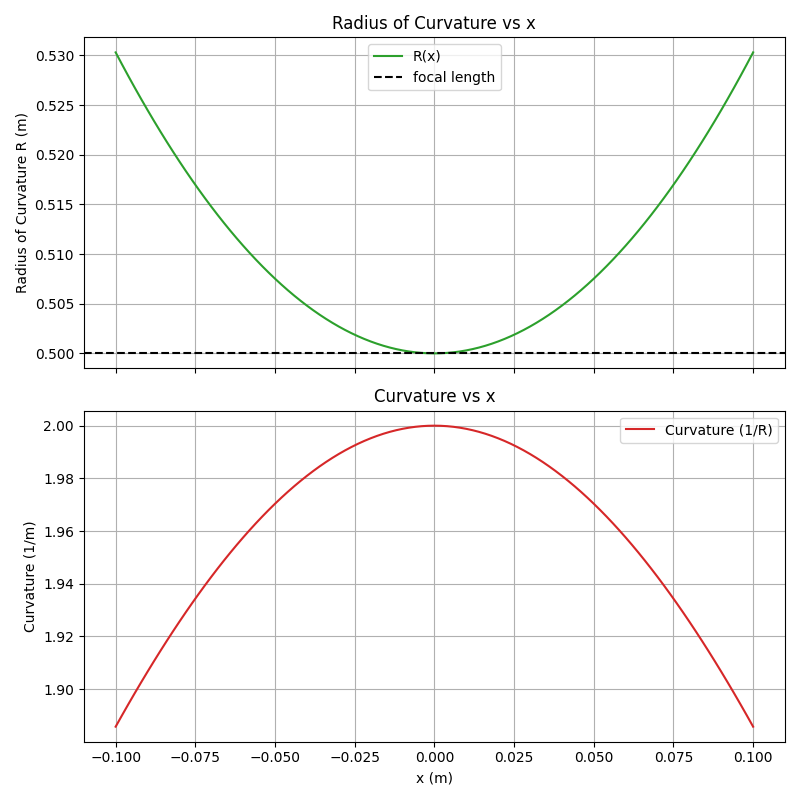

In [4]:
# separate plots for R and curvature
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

ax1.plot(x_line, R_line, 'C2-', label='R(x)')
ax1.axhline(focal_length, color='k', ls='--', label='focal length')
ax1.set_ylabel('Radius of Curvature R (m)')
ax1.set_title('Radius of Curvature vs x')
ax1.grid(True)
ax1.legend()

curvature_line = 1.0 / R_line

ax2.plot(x_line, curvature_line, 'C3-', label='Curvature (1/R)')
ax2.set_xlabel('x (m)')
ax2.set_ylabel('Curvature (1/m)')
ax2.set_title('Curvature vs x')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

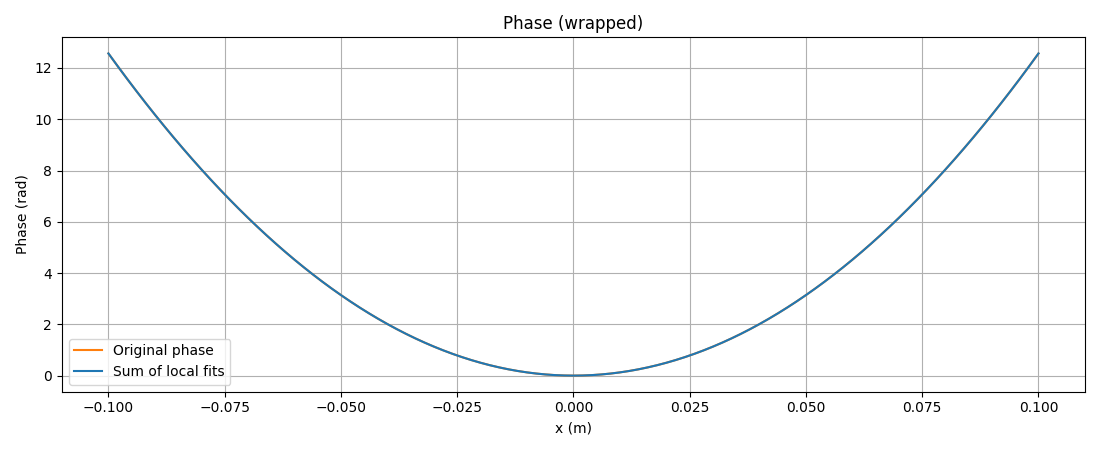

In [5]:
# Phase of original parabola (using optical path length as phase up to constant scale)
lambda0 = 500e-5
two_pi = 2 * jnp.pi
k = 2 * jnp.pi / lambda0

def wrap_pm_pi(phi):
    return (phi + jnp.pi) % two_pi - jnp.pi  # (-π, π]

phi_orig = k * opl_line

# plot osculating parabolas
for i in idx:
    x0 = x_line[i]
    y0 = opl_line[i]
    m0 = slope_line[i]
    R0 = float(R_line[i])

    # build local parabola in a neighborhood of x0
    xx = x0 + parabola_x
    yy = y0 + m0 * (xx - x0) + (xx - x0)**2 / (2 * R0)
    phi_sum = k * yy
# Build and (optionally) average local quadratic phase expansions


fig_phase, ax = plt.subplots(1, 1, figsize=(11, 4.5), sharex=True)
ax.plot(x_line, phi_orig, color='C1', label='Original phase')
ax.plot(x_line, phi_sum, color='C0', label='Sum of local fits')
ax.set_title('Phase (wrapped)')
ax.set_xlabel('x (m)')
ax.set_ylabel('Phase (rad)')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()
